![](https://i.imgur.com/OX1ADxu.png)

# Introduction

With the advances in deep learning and neural networks, it is now possible to create simple yet powerful networks able to perform classification, forecasting and object detection tasks that were previously highly complex and sometimes even infeasible. In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery. They're very powerful at recognizing and classifiying objects and patterns in images when presented with suitable data and a very specific task. However, it turns out at these CNN's are not limited to problems originiating in computer vision, but can also be applied to non-image problems. For instance, a sound can be converted to a spectogram, which is a chart that shows the amount of each frequency at each time in an audio file. It has  been shown that this approach can beat state-of-the-art environmental sound detection models. In this notebook, we'll use CNN's to classify spoken words from the Audio MNIST dataset. The dataset contains 3000 audio files, where a human pronounces one of ten digits (0-9).

Key takeaways from this notebook:

* We convert 3000 MNIST audio files to spectograms.
* We use Tensorflow's API to create a CNN with multiple 2D convolution layers.
* The network prove excellent at classifying the spectograms in 10 distinct classes. 
* Final validation accuracy is about 95%.

First load the data, then print example files and then plot WAV files.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

# Set paths to input and output data
INPUT_DIR = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings/'
OUTPUT_DIR = '/kaggle/working/'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(10):
    print(parent_list[i])

0_yweweler_39.wav
2_george_15.wav
4_lucas_16.wav
1_yweweler_45.wav
9_george_9.wav
0_nicolas_45.wav
6_nicolas_13.wav
7_george_26.wav
1_theo_25.wav
1_theo_36.wav


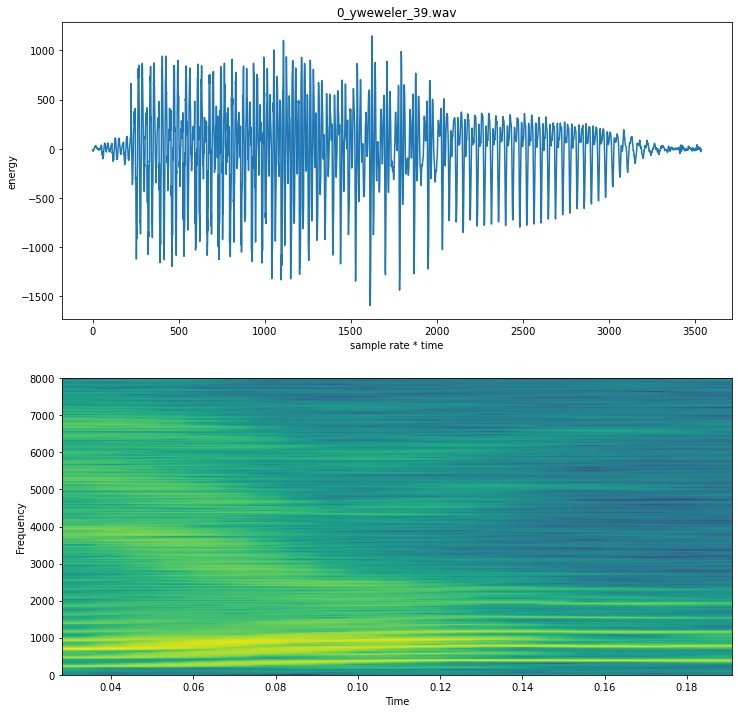

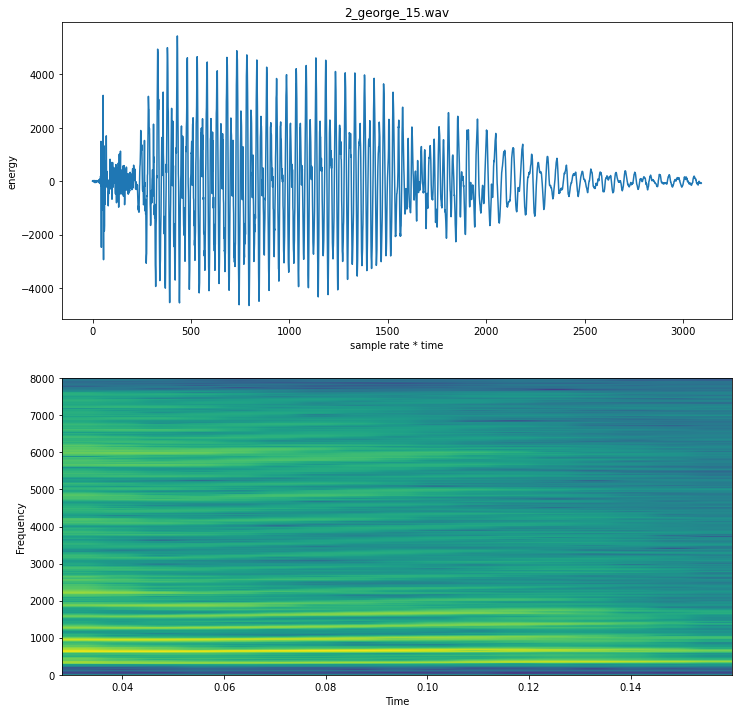

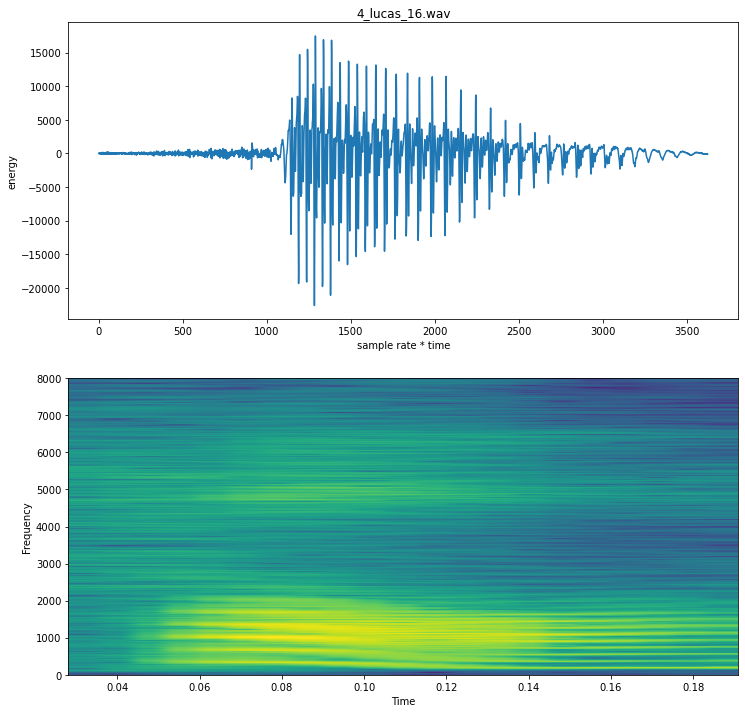

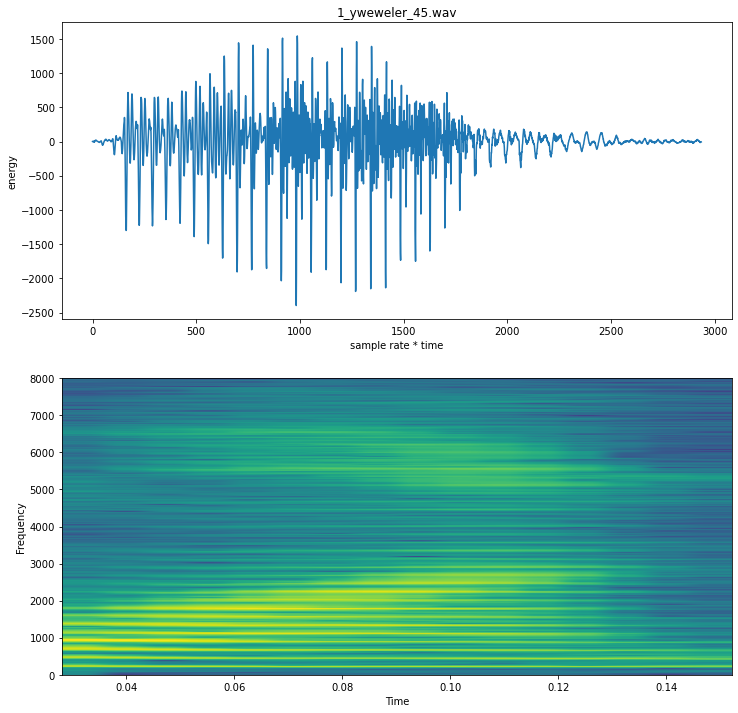

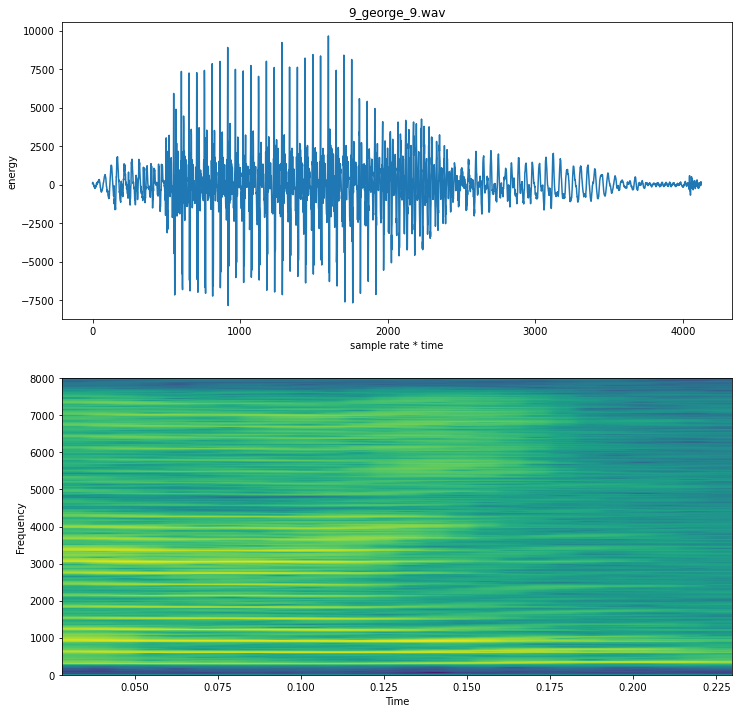

In [2]:
# Plot first 5 WAV files as a waveform and a frequency spectrum
for i in range(5): 
    signal_wave = wave.open(os.path.join(INPUT_DIR, parent_list[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(12,12))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

You can clearly see the difference in the energy distribution when different words are being pronounced. These distinct characteristics also show up in the spectograms of the recordings, which will enable us transform what was originally an audio problem to an image problem.

# Convert audio files to spectograms

We can now do the actual conversion of every audio sample. The code below uses the wave and pylab library to extract sound information and frame rate from each sample and save the result as a spectrogram. After this we've simply converted our audio problem to a image problem.

In [3]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    
for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])
    
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_5
class_7
class_0
class_4
class_8
class_1
class_6
class_2
class_3
class_9

A few example files: 

1_nicolas_23.png
1_george_34.png
1_yweweler_45.png
1_george_14.png
1_jackson_1.png
1_yweweler_43.png
1_george_40.png
1_lucas_17.png
1_george_21.png
1_george_17.png


# Preparing the data

We can now load the spectrograms into memory. We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation. The validation set is what will ultimately be our benchmark when becomes to performance and accuracy of our classifier. The batch size is set fairly low for now (32) for all images to fit in memory. The seed is for reproducibility.

More information: https://keras.io/examples/vision/image_classification_from_scratch/

In [4]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Found 3000 files belonging to 10 classes.
Using 600 files for validation.


Let's quickly visualize a few of the generated spectograms and their labels.

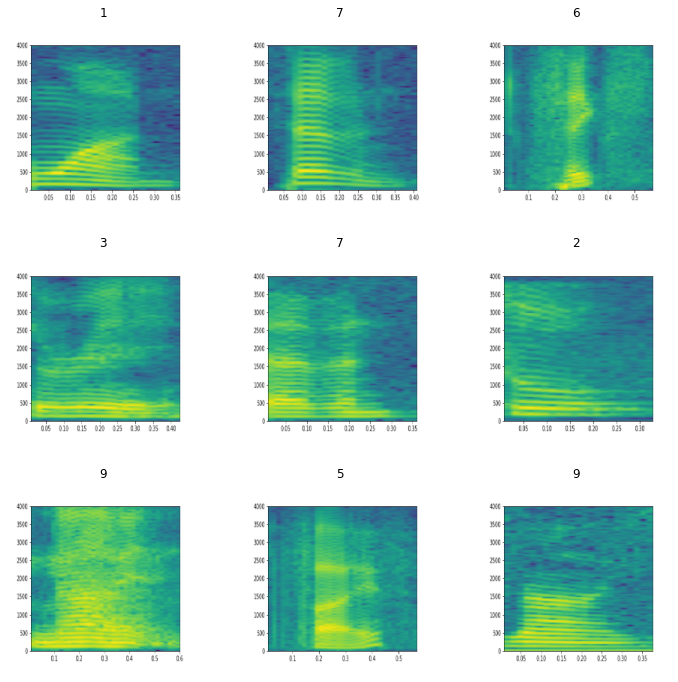

In [5]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

Before we can build our model and start training, we need to apply one simple augmentation the dataset and that is rescaling. We rescale an input in the (0, 255) range to be in the (0,1) range.

In [6]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

# Modelling

![](https://cdn-images-1.medium.com/max/1000/1*ytBUCmhkAucJ5imsNfAyfQ.png)

Keras is one of the most popular deep learning libraries in Python for research and development because of its simplicity and ease of use. It uses the Tensorflow backend to build both shallow and deep models without much hazzle. Since there's a lot of data available here, my belief was that neural network were suiteable. We'll go through why the settings and hyperparameters are set the way they are. See more at https://keras.io/api/

Here we make a neural network using Conv2D and MaxPooling2D layers to downsample the input images into smaller convolutions, which can be seen as a window of the input image. Combining multiple of these convolutions we are able to capture important features in the image such as edges, contours and colors. By iterating over batches of input images and associated labels, we can assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

More here: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [7]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
75/75 [==============================] - 15s 194ms/step - loss: 0.6556 - accuracy: 0.8029 - val_loss: 3.3939 - val_accuracy: 0.1350
Epoch 2/10
75/75 [==============================] - 13s 176ms/step - loss: 0.2366 - accuracy: 0.9408 - val_loss: 2.5236 - val_accuracy: 0.3083
Epoch 3/10
75/75 [==============================] - 13s 175ms/step - loss: 0.1412 - accuracy: 0.9675 - val_loss: 2.5266 - val_accuracy: 0.4017
Epoch 4/10
75/75 [==============================] - 14s 186ms/step - loss: 0.0975 - accuracy: 0.9821 - val_loss: 1.9205 - val_accuracy: 0.5600
Epoch 5/10
75/75 [==============================] - 13s 180ms/step - loss: 0.0649 - accuracy: 0.9850 - val_loss: 0.9362 - val_accuracy: 0.7017
Epoch 6/10
75/75 [==============================] - 14s 181ms/step - loss: 0.0465 - accuracy: 0.9921 - val_loss: 0.9173 - val_accuracy: 0.7067
Epoch 7/10
75/75 [==============================] - 13s 174ms/step - loss: 0.0427 - accuracy: 0.9900 - val_loss: 0.1771 - val_accuracy: 0.9517

After 10 epochs, the training accuracy reaches 99% and validation accuracy reaches 95%.

# Evaluation

To evaluate our CNN, we'll look at the loss and accuracy scores to see how well training's progressed and check if there's any underfit/overfit. Evaluations are based on both the training and the validation set. It seems that after 8 epochs the loss and accuracy for the validation set plateaus just around the 0.10 and 0.95 mark, respectively.

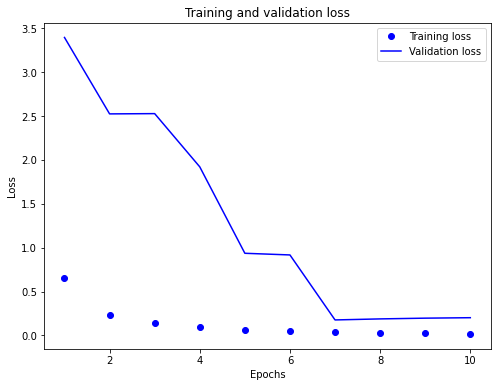

In [8]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

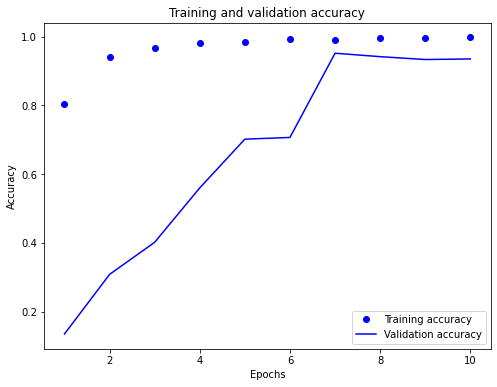

In [9]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can compute the final loss and accuracy score on our valid dataset using the evaluate() function.

In [10]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.202627, final accuracy: 0.935000


In [11]:
# Clean the output dir
import shutil
shutil.rmtree('/kaggle/working/audio-images')